In [27]:
%pylab inline
import matplotlib.image as mpimg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [159]:
with open('data/Calib.txt', 'r') as f:
    text_mat = f.read().split('\n\n')
cal_parameters = map(lambda x: np.fromstring(x, dtype=float, sep=' '), text_mat)
(a, c, b, u0, v0) = cal_parameters[0]
(k1, k2) = cal_parameters[1]
K = np.array([[a, c, u0],
              [0, b, v0],
              [0, 0, 1]])

def make_rotation_matrix(arr):
    arr = arr.reshape(4,3)
    M = np.zeros((3,4))
    M[:,:3] = arr[:3,:]
    M[:,3] = arr[3,:]
    return M
[R1, R2, R3, R4, R5] = map(make_rotation_matrix, cal_parameters[2:])

model = np.loadtxt('data/Model.txt')

data_1 = np.loadtxt('data/data1.txt')
data_2 = np.loadtxt('data/data2.txt')
data_3 = np.loadtxt('data/data3.txt')
data_4 = np.loadtxt('data/data4.txt')
data_5 = np.loadtxt('data/data5.txt')
im_1 =imread('data/CalibIm1.gif')
im_2 =imread('data/CalibIm2.gif')
im_3 =imread('data/CalibIm3.gif')
im_4 =imread('data/CalibIm4.gif')
im_5 =imread('data/CalibIm5.gif')

im_1_u = imread('data/UndistortIm1.gif')
im_2_u = imread('data/UndistortIm2.gif')

## Visualize images and corners

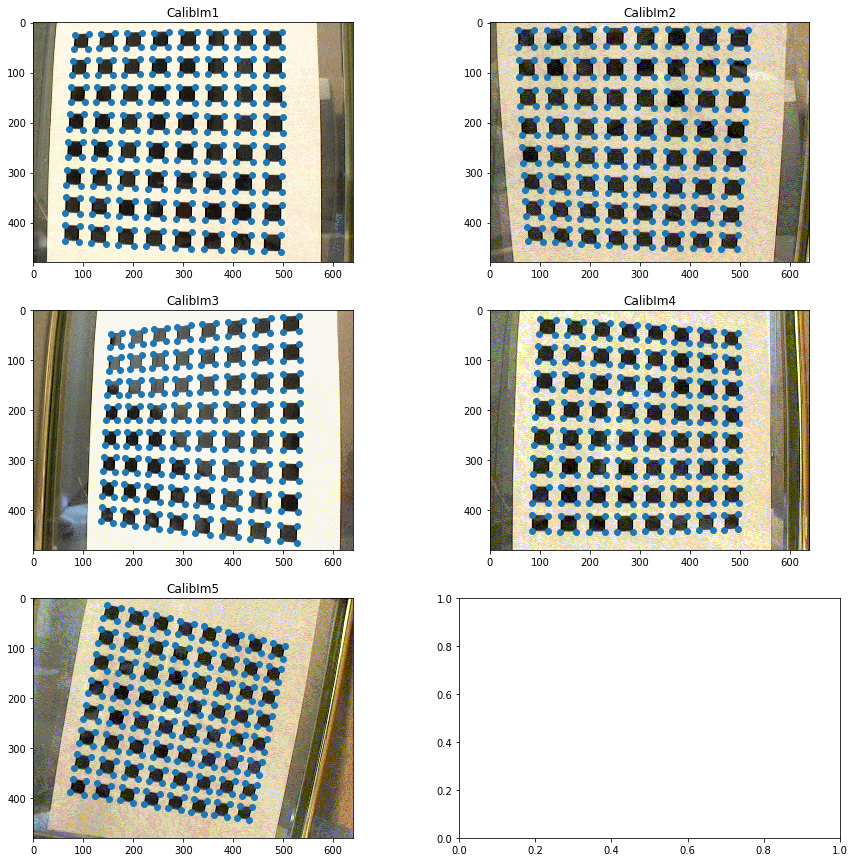

In [213]:
rcParams['figure.figsize'] = 15, 15
f, axs = plt.subplots(3, 2)
for i, (img, points) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], [data_1, data_2, data_3, data_4, data_5])):
    axs[i/2, i%2].imshow(img)
    axs[i/2, i%2].scatter(points.reshape(64*4, 2)[:, 0], points.reshape(64*4, 2)[:, 1])
    axs[i/2, i%2].set_title('CalibIm{}'.format(i+1))

In [382]:
def radial_distortion(points, K, R, k1=None, k2=None, u0=None, v0=None):
    dim_x = 2
    dim_y = points.shape[0] * points.shape[1]/dim_x
    
    points = points.reshape((dim_y, dim_x))
    
    if k1 is not None and k2 is not None and u0 is not None and v0 is not None:
        max_dim = np.array([480, 640])
        min_dim = np.array([0, 0])
        normalized = (points - min_dim) / (max_dim - min_dim)[None, :]
        xy2 = np.sum(normalized**2, axis=1)
        term = (k1*xy2 + k2*xy2**2)
        new_x = points[:, 0] + (points[:, 0] - u0) * term
        new_y = points[:, 1] + (points[:, 1] - v0) * term
        points = np.hstack((new_x[:, None], new_y[:,None]))
    
    R = R[:, None, :]
    K = K[:, None, :]
    
    d3_points = np.hstack((points, np.zeros((dim_y, 1)), np.ones((dim_y, 1))))
    
    tmp = R.dot(d3_points.T)[:, 0, :]
    res = K.dot(tmp)[:, 0, :].T
    res = res[:, :2]/res[:, 2, None]
    
#     if k1 is not None and k2 is not None and u0 is not None and v0 is not None:
#         max_dim = np.array([480, 640])
#         min_dim = np.array([0, 0])
#         normalized = (res - min_dim) / (max_dim - min_dim)[None, :]
#         xy2 = np.sum(normalized**2, axis=1)
#         term = (k1*xy2 + k2*xy2**2)
#         new_x = res[:, 0] + (res[:, 0] - u0) * term
#         new_y = res[:, 1] + (res[:, 1] - v0) * term
#         res = np.hstack((new_x[:, None], new_y[:,None]))
    
    
    return res

In [378]:
model.reshape((64*4, 2)).max(axis=0)

array([ 6.72222,  0.     ])

In [381]:
model.reshape((64*4, 2)).min(axis=0)

array([ 0.     , -6.72222])

## Visualize model points on undistorted images

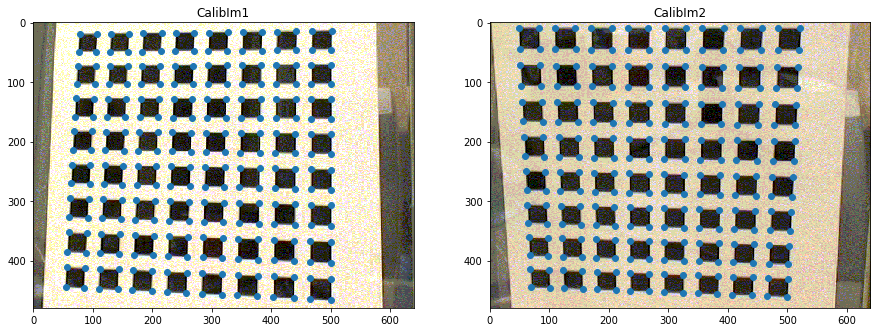

In [366]:
f, axs = plt.subplots(1, 2)
for i, (img, points) in enumerate(zip([im_1_u, im_2_u], [radial_distortion(model, K, R1), radial_distortion(model, K, R2)])):
    axs[i].imshow(img)
    axs[i].scatter(points[:, 0], points[:, 1])
    axs[i].set_title('CalibIm{}'.format(i+1))

## Visualize model points on distorted images

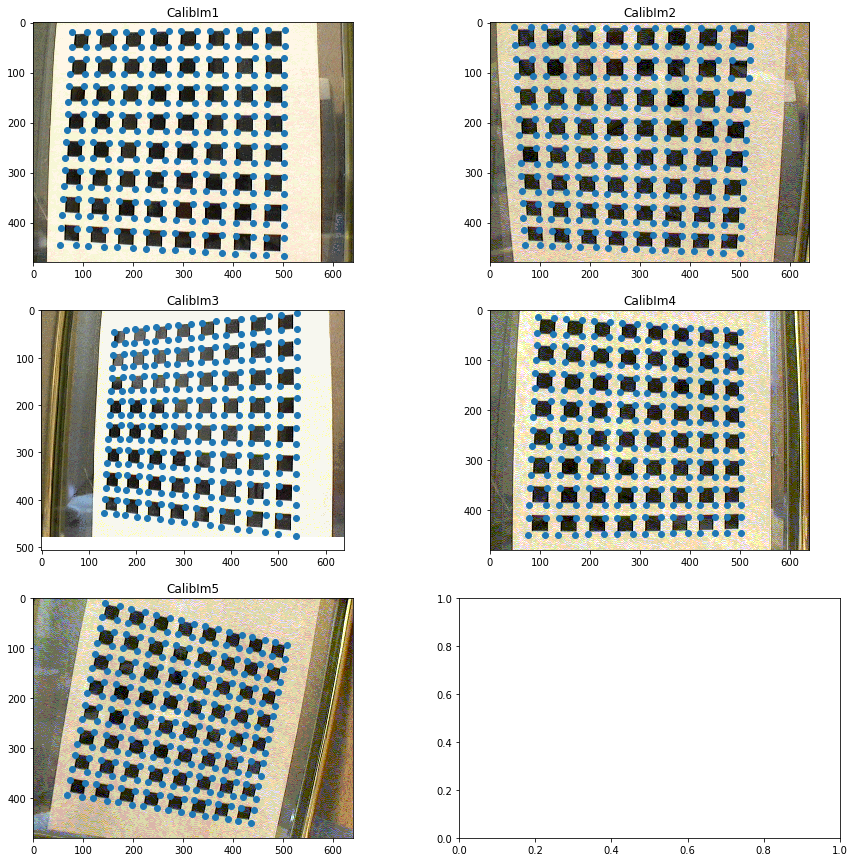

In [383]:
rcParams['figure.figsize'] = 15, 15
f, axs = plt.subplots(3, 2)
for i, (img, points) in enumerate(zip([im_1, im_2, im_3, im_4, im_5], 
                                      [radial_distortion(model, K, R, k1=k1, k2=k2, u0=u0, v0=v0) for R in [R1, R2, R3, R4, R5]])):
    axs[i/2, i%2].imshow(img)
    axs[i/2, i%2].scatter(points[:, 0], points[:, 1])
    axs[i/2, i%2].set_title('CalibIm{}'.format(i+1))